## 1. Import and Install Dependencies

### 1.1 Install Dependencies

In [ ]:
%pip install tensorflow tensorflow-io matplotlib

### 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import numpy

## 2. Build Data Loading Function

### 2.1 Define Paths to Files

In [15]:
ZOMBIE_DEATH_FILE = os.path.join('data', 'Mobs\Death', 'zombie 46.wav')
WITHER_DEATH_FILE = os.path.join('data', 'Mobs\Death', 'wither 106.wav')
print(ZOMBIE_DEATH_FILE)

data\Mobs\Death\zombie 46.wav


### 2.2 Build Dataloading Function

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

### 2.3 Plot Wave

In [16]:
wave = load_wav_16k_mono(WITHER_DEATH_FILE)
nwave = load_wav_16k_mono(ZOMBIE_DEATH_FILE)

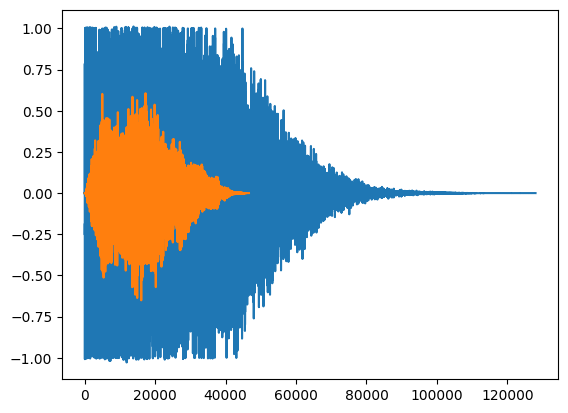

In [17]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## 3. Create Tensorflow Dataset

### 3.1 Define Paths to Positive and Negative Data

In [19]:
POS = os.path.join('data', 'Break')
NEG = os.path.join('data', 'Other')

### 3.2 Create Tensorflow Datasets

In [20]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

### 3.3 Add labels and Combine Positive and Negative Samples

In [21]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [46]:
negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

(b'data\\Other\\dolphin 63.wav', 0.0)

## 4. Determine Average Length of a Capuchin Call

### 4.1 Calculate Wave Cycle Length

In [47]:
lengths = []
for file in os.listdir(os.path.join('data', 'Break')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Break', file))
    lengths.append(len(tensor_wave))

In [48]:
lengths

[19804,
 20518,
 30520,
 24921,
 69159,
 44816,
 54721,
 54409,
 45894,
 45894,
 54721,
 47718,
 23650,
 45596,
 54721,
 54409,
 45894,
 44816,
 47718,
 45596,
 18729,
 10521,
 10521,
 10521,
 10521,
 26234,
 22769,
 26474,
 23203,
 30584,
 25084,
 26234,
 22769,
 30520,
 24921,
 8048,
 8033,
 8244,
 8056,
 8130,
 21911,
 12819,
 12919,
 14985,
 13779,
 14269,
 8927,
 13715,
 13775,
 10655,
 11693,
 12091,
 6544,
 8187,
 8751,
 5345,
 5727,
 7188,
 7117,
 7326,
 12676,
 6554,
 9554,
 6656,
 6868,
 7963,
 6774,
 6518,
 8564,
 7120,
 5578,
 7200,
 5200,
 5950,
 6450,
 6450,
 6390,
 6495,
 6338,
 6924,
 6419,
 5748,
 4626,
 4046,
 4888,
 4869,
 3317,
 10095,
 11793,
 10095,
 10095,
 10095,
 14408,
 14479,
 13662,
 14413,
 14531,
 11571,
 5919,
 20812,
 19942,
 20648,
 20964,
 17051,
 17051,
 17051,
 17051,
 10095,
 10095,
 10095,
 10095,
 14408,
 14479,
 13662,
 14413,
 14441,
 14441,
 14470,
 14441,
 11399,
 11943,
 13030,
 8028,
 8009,
 8000,
 8018,
 8130,
 9758,
 7770,
 6793,
 8775,
 9

### 4.2 Calculate Mean, Min and Max

In [49]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=15405>

In [50]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=1682>

In [51]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=113078>

## 5. Build Preprocessing Function to Convert to Spectrogram

### 5.1 Build Preprocessing Function

In [52]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:113078]
    zero_padding = tf.zeros([113078] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

### 5.2 Test Out the Function and Viz the Spectrogram

In [53]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [54]:
spectrogram, label = preprocess(filepath, label)

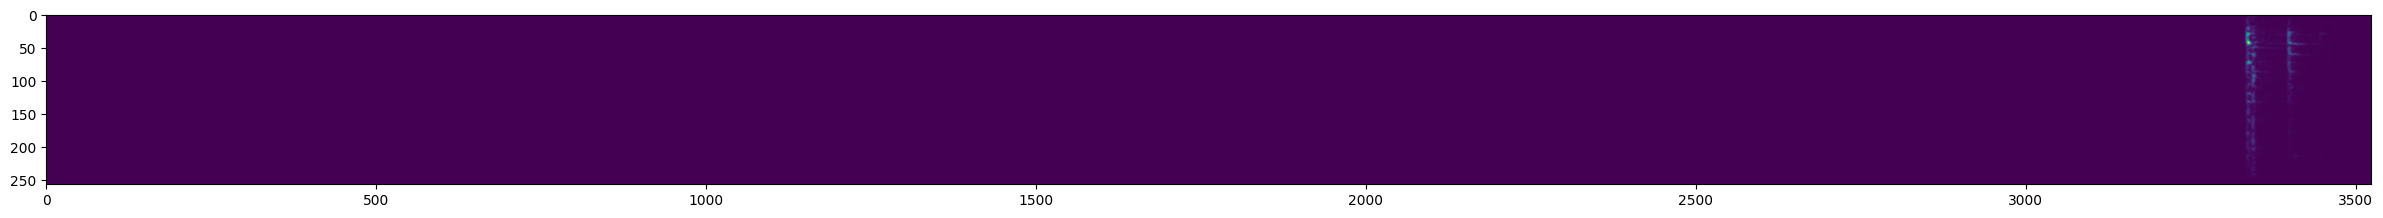

In [55]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## 6. Create Training and Testing Partitions

### 6.1 Create a Tensorflow Data Pipeline

In [56]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

### 6.2 Split into Training and Testing Partitions

In [59]:
len(data)

132

In [60]:
train = data.take(92)
test = data.skip(92).take(40)

### 6.3 Test One Batch

In [61]:
samples, labels = train.as_numpy_iterator().next()

In [62]:
samples.shape

(16, 3524, 257, 1)

## 7. Build Deep Learning Model

### 7.1 Load Tensorflow Dependencies

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

### 7.2 Build Sequential Model, Compile and View Summary

In [64]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(3524, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [65]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3522, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 3520, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 14248960)          0         
                                                                 
 dense (Dense)               (None, 128)               1823867008
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,823,869,617
Trainable params: 1,823,869,617
Non-trainable params: 0
_________________________________________________________________


### 7.3 Fit Model, View Loss and KPI Plots


In [67]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
31/92 [=========>....................] - ETA: 17:24 - loss: 15.4763 - recall: 0.9790 - precision: 0.8624

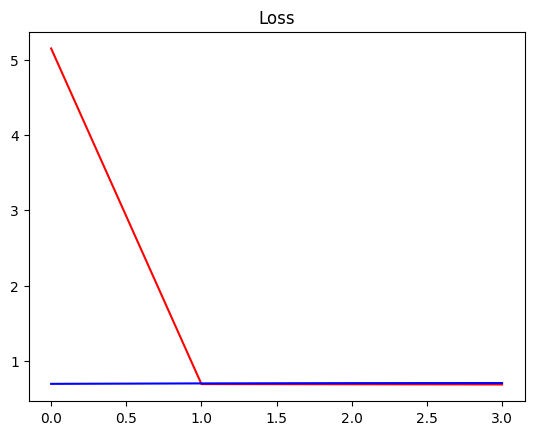

In [27]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

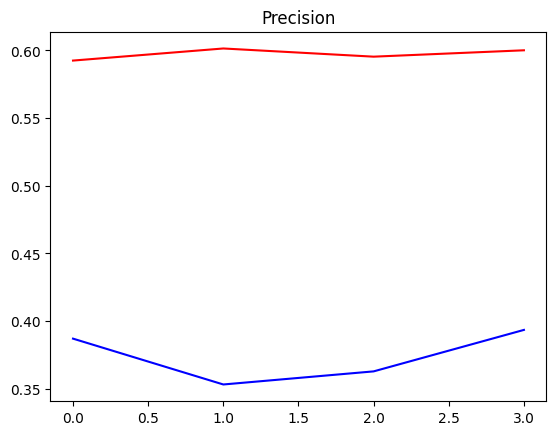

In [28]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

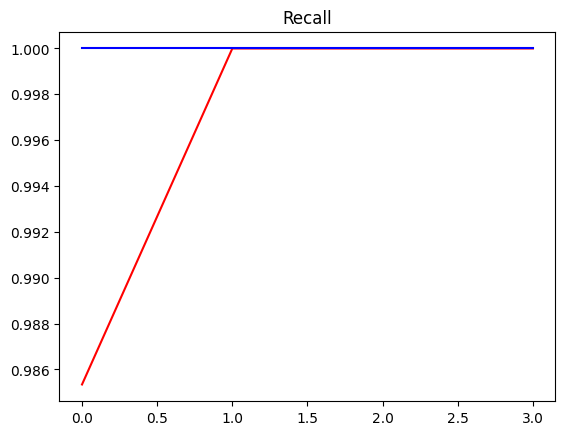

In [29]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

## 8. Make a Prediction on a Single Clip

### 8.1 Get One Batch and Make a Prediction

In [30]:
X_test, y_test = test.as_numpy_iterator().next()

In [31]:
X_test.shape

(16, 3524, 257, 1)

In [32]:
yhat = model.predict(X_test)

### 8.2 Convert Logits to Classes

In [33]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [34]:
yhat

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [35]:
y_test.astype(int)

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

## 9. Build Forest Parsing Functions

### 9.1 Load up MP3s


In [36]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [37]:
mp3 = os.path.join('data', 'Test', 'Test7.mp3')

In [38]:
wav = load_mp3_16k_mono(mp3)

In [50]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=113078, sequence_stride=113078, batch_size=1)

In [51]:
samples, index = audio_slices.as_numpy_iterator().next()

In [52]:
len(audio_slices)

4

### 9.2 Build Function to Convert Clips into Windowed Spectrograms


In [53]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([113078] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

### 9.3 Convert Longer Clips into Windows and Make Predictions


In [54]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=113078, sequence_stride=113078, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [55]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [56]:
yhat

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### 9.4 Group Consecutive Detections

In [57]:
from itertools import groupby

In [58]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [59]:
calls

1

## 10. Make Predictions

### 10.1 Loop over all recordings and make predictions


In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=113078, sequence_stride=113078, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

### 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

### 10.3 Group Consecutive Detections


In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

## 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])